<a href="https://colab.research.google.com/github/Ryoseal/for_public/blob/main/Numerai_signals_Data_upload_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries
import libraries what we need...
driveにはKaggle API keyと各種ライブラリを入れておいて、mount

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
import sys
sys.path.append('/content/drive/MyDrive/numerai_module') #pipしなくていいように自分のdriveにmount

Mounted at /content/drive


In [2]:
#kaggleフォルダを作成、元々"./drive/MyDrive/Kaggle"に入れてあるkaggle.jsonを複製してsignalsフォルダに入れる

! mkdir -p ~/.kaggle
! mkdir /content/signals
! cp ./drive/MyDrive/Kaggle/kaggle.json ~/.kaggle/
! cp ./drive/MyDrive/dataset-metadata.json /content/signals/

#jsonファイルのpermissionを付与
! chmod 600 ~/.kaggle/kaggle.json
! chmod 600 /content/signals/dataset-metadata.json

In [3]:
#import 不要な物も入ってるかも

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pyarrow.parquet as pq
import json
import time
import requests as re
from datetime import datetime
#月末日を算出する用
from dateutil.relativedelta import relativedelta, FR
import pickle
import yfinance
import simplejson
import numerapi

import warnings
warnings.simplefilter('ignore')

# Config
A simple config and logging setup.

In [4]:
today = datetime.now().strftime('%Y-%m-%d')
today

'2022-04-26'

In [5]:
# config class
class CFG:
    INPUT_DIR = '/content/signals/full_data.parquet'
    OUTPUT_DIR = './'
    FETCH_VIA_API = True

In [6]:
# Logging is always nice for your experiment:)
def init_logger(log_file='train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

logger = init_logger(log_file=f'{CFG.OUTPUT_DIR}/{today}.log')
logger.info('Start Logging...')

Start Logging...


# Setup Numerai API
First of all, let's set up the numerai signals API. 

We can do many things with this API: 

- get a ticker map (between yfinance data and numerai historical targets)
- get the historical targets
- get your model slot name and model_id (if private key and secret key are provided)
- submit

(well, maybe more)

## Get Tickers for Numerai Signals
Let's first get the ticker map.

In [7]:
napi = numerapi.SignalsAPI()
logger.info('numerai api setup!')

# read in list of active Signals tickers which can change slightly era to era
eligible_tickers = pd.Series(napi.ticker_universe(), name='ticker') 
logger.info(f"Number of eligible tickers: {len(eligible_tickers)}")

# read in yahoo to numerai ticker map, still a work in progress, h/t wsouza and 
# this tickermap is a work in progress and not guaranteed to be 100% correct
ticker_map = pd.read_csv('https://numerai-signals-public-data.s3-us-west-2.amazonaws.com/signals_ticker_map_w_bbg.csv')
ticker_map = ticker_map[ticker_map.bloomberg_ticker.isin(eligible_tickers)]

numerai_tickers = ticker_map['ticker']
yfinance_tickers = ticker_map['yahoo']
logger.info(f"Number of eligible tickers in map: {len(ticker_map)}")

numerai api setup!
2022-04-26 12:29:48,331 INFO __main__: numerai api setup!
Number of eligible tickers: 5324
2022-04-26 12:29:49,222 INFO __main__: Number of eligible tickers: 5324
Number of eligible tickers in map: 5324
2022-04-26 12:29:50,330 INFO __main__: Number of eligible tickers in map: 5324


# Load Stock Price Data
Now is the time to get the stock price data, fetched via the [YFiance API](https://pypi.org/project/yfinance/).

The good thing with this API is that it is free of charge.

The bad thing with this API is that the data is often not complete.

For a better quality of stock price data, you might want to try out purchasing one from [Quandl](https://www.quandl.com/data/EOD-End-of-Day-US-Stock-Prices/documentation?anchor=overview).

This is another starter using Quandl data:
https://forum.numer.ai/t/signals-plugging-in-the-data-from-quandl/2431

This is of course wonderful, but if you are a beginner, why not just start with a free one?

In [8]:
# If you want to fetch the data on your own, you can use this function...

def fetch_yfinance(ticker_map, start='2002-12-01'):
    """
    # fetch yfinance data
    :INPUT:
    - ticker_map : Numerai eligible ticker map (pd.DataFrame)
    - start : date (str)
    
    :OUTPUT:
    - full_data : pd.DataFrame ('date', 'ticker', 'close', 'raw_close', 'high', 'low', 'open', 'volume')
    """
    
    # ticker map
    numerai_tickers = ticker_map['ticker']
    yfinance_tickers = ticker_map['yahoo']

    # fetch
    raw_data = yfinance.download(
        yfinance_tickers.str.cat(sep=' '), 
        start=start, 
        threads=True
    ) 
    
    # format
    cols = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume',]
    full_data = raw_data[cols].stack().reset_index()
    full_data.columns = ['date', 'ticker', 'raw_close', 'close', 'high', 'low', 'open', 'volume']
    full_data['date'] = pd.to_datetime(full_data['date'], format='%Y-%m-%d').dt.strftime('%Y%m%d').astype(int)
    
    # map yfiance ticker to numerai tickers
    full_data['ticker'] = full_data.ticker.map(
        dict(zip(yfinance_tickers, numerai_tickers))
    )
    return full_data

In [9]:
%%time

if CFG.FETCH_VIA_API: # fetch data via api
    logger.info('Fetch data via API...may take some time...')

    
    df = fetch_yfinance(ticker_map, start='2002-12-01')
    df.to_parquet("./signals/df.parquet")

else: # loading from the kaggle dataset
    logger.info('fetch_via_api = False.')

[**********************55%*                      ]  2882 of 5269 completed

KeyboardInterrupt: ignored

[**********************55%*                      ]  2885 of 5269 completed

In [ ]:
#raw_closeは使わないので削除、adjust closeをcloseとする
df = df.drop(columns = 'raw_close')

df.tail() #dateが最新の日付になっているか確認

In [ ]:

#!kaggle datasets init -p signals #kaggle datasetをまだ作成してなかったらこのコマンドでjsonファイルを作成、jsonファイル内のidとurlを自分のアップロードしたい所に書き換える
#Upload to  https://www.kaggle.com/ryostock/yfinance-ohlcv-for-signals2
!kaggle datasets version -p signals -m updated #signalsフォルダ内に移動したjsonファイルを参照してdownloadしたfull_datを

Updated dateが最新になってlink作成されてたらupload成功

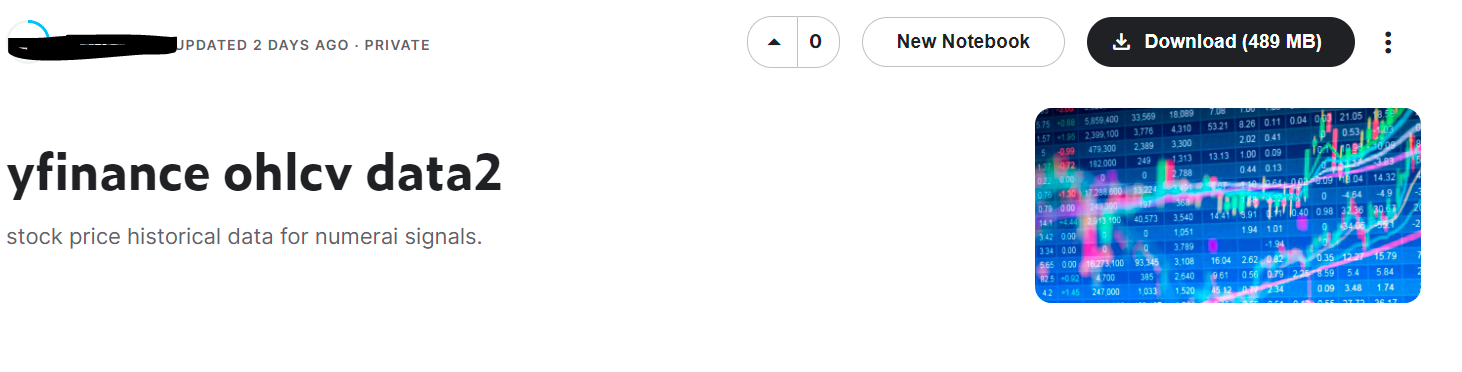